<a href="https://colab.research.google.com/github/abdulganiyMK007/freeCodeCamp-Project-Files/blob/master/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 625.6/625.6 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.0 MB/s eta 0:00:00
2.19.0-dev20241114


In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2024-11-15 13:55:57--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.01s   

2024-11-15 13:55:57 (25.2 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2024-11-15 13:55:57--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

## Setup input pipeline

In [ ]:
train_dataset = pd.read_csv(train_file_path, sep="\t", header=None, names=["type", "msg"])
test_dataset = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])

In [ ]:
print(train_dataset.shape)
print(test_dataset.shape)

(4179, 2)
(1392, 2)


In [ ]:
train_dataset.head()

,type,msg
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [ ]:
train_dataset['type'] = train_dataset['type'].map({'ham': 0, 'spam': 1})
test_dataset['type'] = test_dataset['type'].map({'ham': 0, 'spam': 1})

In [ ]:
train_dataset.head()

,type,msg
0,0,ahhhh...just woken up!had a bad dream about u ...
1,0,you can never do nothing
2,0,"now u sound like manky scouse boy steve,like! ..."
3,0,mum say we wan to go then go... then she can s...
4,0,never y lei... i v lazy... got wat? dat day ü ...


In [ ]:
# train_input = train_dataset['msg']
# test_input = test_dataset['msg']

# train_labels = train_dataset.pop('type')
# test_labels = test_dataset.pop('type')

In [ ]:
BUFFER_SIZE = 250
BATCH_SIZE = 64

In [ ]:
# Convert the DataFrame to a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
          tf.cast(train_dataset['msg'].values, tf.string),
          tf.cast(train_dataset['type'].values, tf.int32)
    )
)

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'


In [ ]:
# Convert the DataFrame to a tf.data.Dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    (
          tf.cast(test_dataset['msg'].values, tf.string),
          tf.cast(test_dataset['type'].values, tf.int32)
    )
)

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for msg, label in train_dataset.take(1):
    print('texts: ', msg.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b"how's ur paper?" b'so dont use hook up any how'
 b'you are a winner u have been specially selected 2 receive \xc2\xa31000 cash or a 4* holiday (flights inc) speak to a live operator 2 claim 0871277810810']

labels:  [0 0 1]


## Create the text encoder

In [ ]:
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
)

encoder.adapt(train_dataset.map(lambda text, label: text))


In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'to', 'i', 'you', 'a', 'the', 'u', 'and', 'in', 'is',
       'me', 'my', 'for', 'your', 'of', 'it', 'call', 'have', 'on'],
      dtype='<U15')

In [ ]:
encoded_example = encoder(msg)[:3].numpy()
encoded_example

array([[271,  37, 865,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [ 27,  47, 294,   1,  43, 109,  52,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  4,  21,   5, 609,   7,  18,  97, 854, 415,  24, 320, 361, 171,
         29,   5,  45, 266,   1,   1, 379,   2,   5, 299, 668,  24, 138,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]])

In [ ]:
for n in range(3):
  print("Original: ", msg[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"how's ur paper?"
Round-trip:  hows ur paper                                     

Original:  b'so dont use hook up any how'
Round-trip:  so dont use [UNK] up any how                                 

Original:  b'you are a winner u have been specially selected 2 receive \xc2\xa31000 cash or a 4* holiday (flights inc) speak to a live operator 2 claim 0871277810810'
Round-trip:  you are a winner u have been specially selected 2 receive £1000 cash or a 4 holiday [UNK] [UNK] speak to a live operator 2 claim [UNK]             



## Create a Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Convert sample_text to a tf.Tensor of strings
sample_text_tensor = tf.convert_to_tensor([sample_text])

# Predict using the model
predictions = model.predict(sample_text_tensor)

# predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[0.49912655]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000

# Convert sample_text to a tf.Tensor of strings
sample_text_tensor = tf.convert_to_tensor([sample_text, padding])

# Predict using the model
predictions = model.predict(sample_text_tensor)

# predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
[0.49912655]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train a Model

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:743: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.8684 - loss: 0.6687 - val_accuracy: 0.8657 - val_loss: 0.5545
Epoch 2/10
 1/66 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9062 - loss: 0.5340

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.8694 - loss: 0.5095 - val_accuracy: 0.8657 - val_loss: 0.4206
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.8679 - loss: 0.3865 - val_accuracy: 0.8671 - val_loss: 0.2877
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.8967 - loss: 0.2386 - val_accuracy: 0.9540 - val_loss: 0.1770
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.9657 - loss: 0.1539 - val_accuracy: 0.9698 - val_loss: 0.1238
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.9715 - loss: 0.1029 - val_accuracy: 0.9756 - val_loss: 0.0882
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9790 - loss: 0.0744 - val_accuracy: 0.9792 - val_loss: 0.0766
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9836 - loss: 0.0590 - val_accuracy: 0.9806 - val_loss: 0.0697
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.9873 - loss: 0.0488 - val_accuracy: 0.9820 - va

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (1, None)                   │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (1, None, 64)               │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (1, 128)                    │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 64)                     │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 415,109 (1.58 MB)

 Trainable params: 138,369 (540.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 276,740 (1.06 MB)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9881 - loss: 0.0599
Test Loss: 0.06207484379410744
Test Accuracy: 0.9841954112052917


In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6723992204293608)

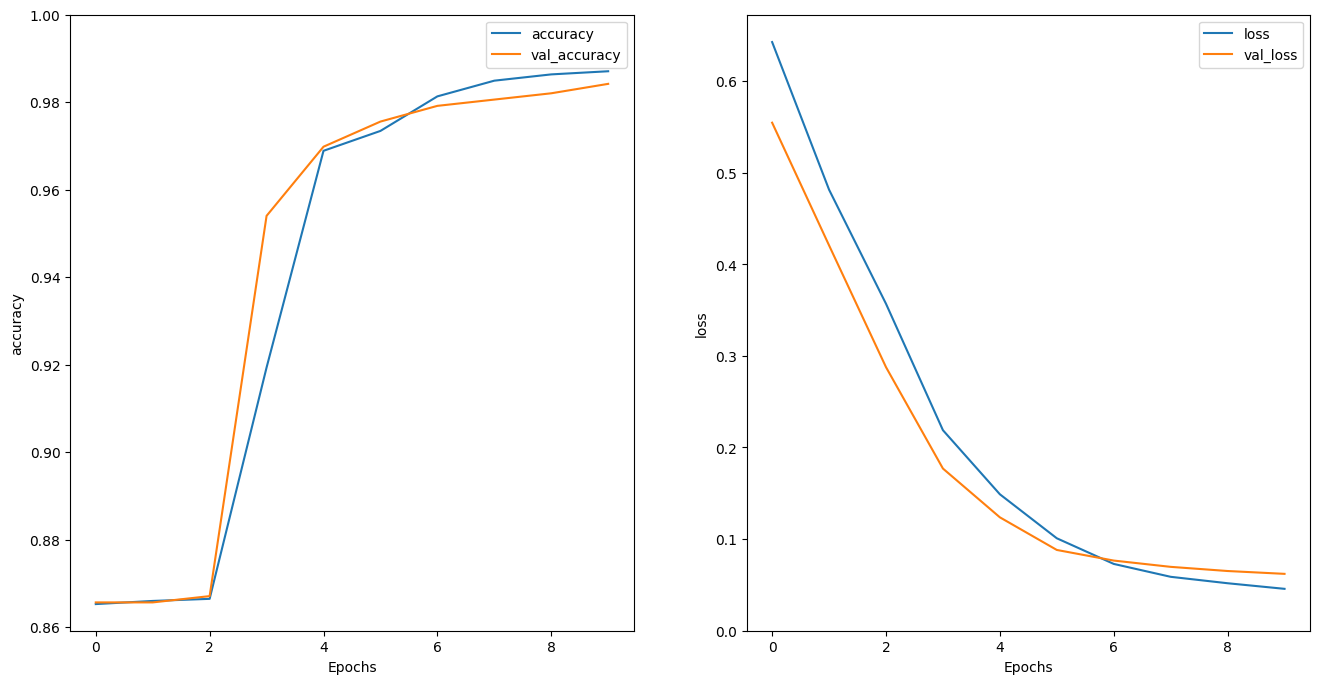

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

## Test Model

In [ ]:
text_input = ["Your input text here"]
text_input_tensor = tf.convert_to_tensor(text_input)
predictions = model.predict(text_input_tensor)

# The predictions will be between 0 and 1
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
[[0.43529466]]


In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    pred_text_tensor = tf.convert_to_tensor([pred_text])
    prediction = model.predict(pred_text_tensor)

    if prediction > 0.5:
        return [prediction, 'spam']
    else:
        return [prediction, 'ham']

In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
You passed the challenge. Great job!
